In [15]:
import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure 1: Sampling in San Diego and Baja California is proportion to cases.

In [46]:
cases = pd.read_csv( "../analyses/estimated-importation-risk/back-calculated-infections.csv", usecols=["date", "location", "cases"], parse_dates=["date"] )
sd_cases = cases.loc[cases["location"]=="San Diego County"].copy()
sd_cases["date"] = pd.to_datetime( sd_cases["date"] )
sd_cases.head()

,date,location,cases
155249,2020-01-20,San Diego County,0
155250,2020-01-21,San Diego County,0
155251,2020-01-22,San Diego County,0
155252,2020-01-23,San Diego County,0
155253,2020-01-24,San Diego County,0


In [56]:
bc_cases = pd.read_csv( "../data/cases_mexico.csv", index_col="nombre" )
bc_cases = bc_cases.drop( columns=["cve_ent", "poblacion"] )
bc_cases = bc_cases.T
bc_cases.index = pd.to_datetime( bc_cases.index, format="%d-%m-%Y" )
bc_cases = bc_cases["BAJA CALIFORNIA"].reset_index()
bc_cases.columns = ["date", "cases"]
bc_cases.head()

,date,cases
0,2020-02-18,0
1,2020-02-19,0
2,2020-02-20,0
3,2020-02-21,0
4,2020-02-22,0


In [22]:
def get_location_sequences( entry ):
    return_df = entry.copy()
    return_df["week"] = return_df["date_collected"].apply( lambda x: Week.fromdate(x).startdate() )
    return_df = return_df.groupby( "week" )["strain"].agg( "count" )
    return_df.name = "sequences"
    return_df = return_df.reset_index()
    return_df["week"] = pd.to_datetime(return_df["week"])
    return return_df

md = pd.read_csv( "../data/metadata_filtered.tsv", sep="\t", usecols=["strain", "date_collected", "country", "division", "location"], parse_dates=["date_collected"] )
sd_seqs = get_location_sequences( md.loc[(md["division"]=="California")&(md["location"].str.startswith( "San Diego"))])
bc_seqs = get_location_sequences( md.loc[(md["division"]=="Baja California")] )
sd_seqs.head()

,week,sequences
0,2020-03-01,1
1,2020-03-08,29
2,2020-03-15,34
3,2020-03-22,90
4,2020-03-29,123


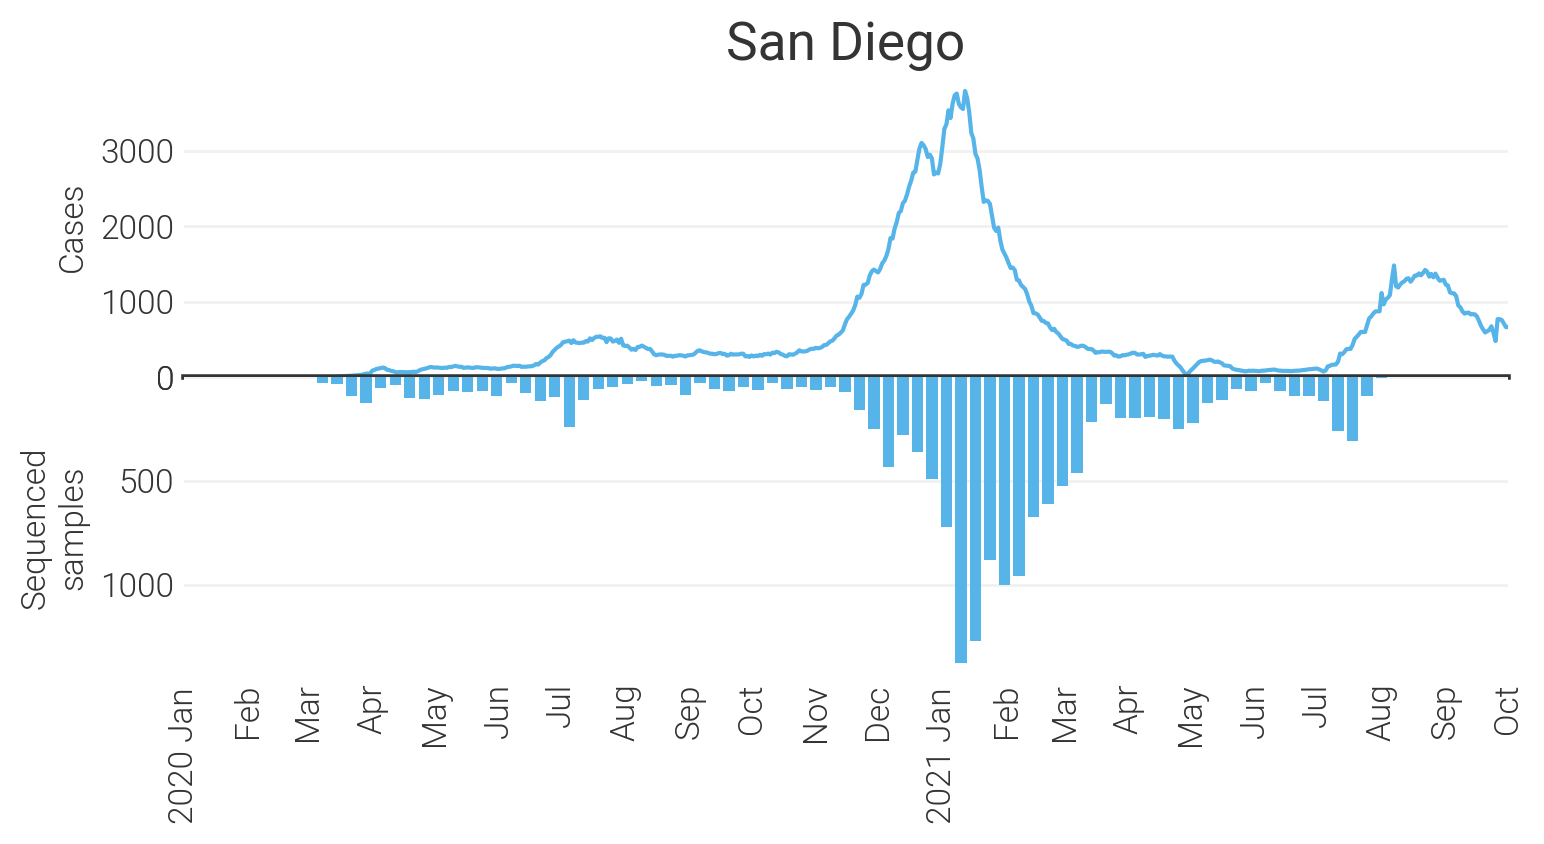

In [66]:
def plot_cases_sequences( axis, case_df, sequences, title, color ):
    def add_time_formatting( axis ):
        axis.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1 )
        [axis.spines[j].set_visible(False) for j in ax.spines]

        axis.tick_params( axis="x", bottom=False, which="both", labelbottom=True )
        axis.tick_params( axis="y", left=False, which="both", labelleft=True )

    ax.plot( case_df["date"], case_df["cases"].rolling( 7 ).mean(), zorder=5, color=color, solid_capstyle="round" )

    divider = make_axes_locatable( ax )
    ax2 = divider.append_axes( "bottom", size="100%", pad=0, sharex=ax )

    ax2.bar( x=sequences["week"], height=sequences["sequences"], width=5.5, zorder=5, color=color )
    ax2.invert_yaxis()

    date_range = ( pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-10-01") )
    basic_formatting( ax, ylabel="Cases", xlims=date_range )
    timeseries_formatting( ax )
    basic_formatting( ax2, ylabel="Sequenced\nsamples", spines=[], xlims=date_range )
    timeseries_formatting( ax2 )

    #ax.set_ylabel( "Cases" )
    #ax2.set_ylabel( "Sequenced\nsamples" )
    ax.set_ylim( 0 )
    #add_time_formatting( ax )
    #add_time_formatting( ax2 )
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color( COLOR )
    ax.spines["bottom"].set_linewidth( 2 )
    ax.spines["bottom"].set_zorder( 10 )
#
    #ax2.xaxis.set_minor_locator( mdates.MonthLocator(interval=1) )
    #ax2.xaxis.set_minor_formatter( mdates.DateFormatter( '%b' ) )
    #ax2.xaxis.set_major_locator( mdates.YearLocator() )
    #ax2.xaxis.set_major_formatter( mdates.DateFormatter( '%Y %b' ) )
    #ax2.tick_params( axis="x", which="both", rotation=90 )
#
    ax.tick_params( which="both", bottom=False, labelbottom=False )
    ax.set_title( title )
    #ax.set_xlim

plt.figure( dpi=200, figsize=(8,4.5) )
ax = plt.subplot()
plot_cases_sequences( ax, cases.loc[cases["location"]=="San Diego County"], sd_seqs, "San Diego", color="#56B4E9" )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_san-diego-sampling.pdf" )
plt.show()

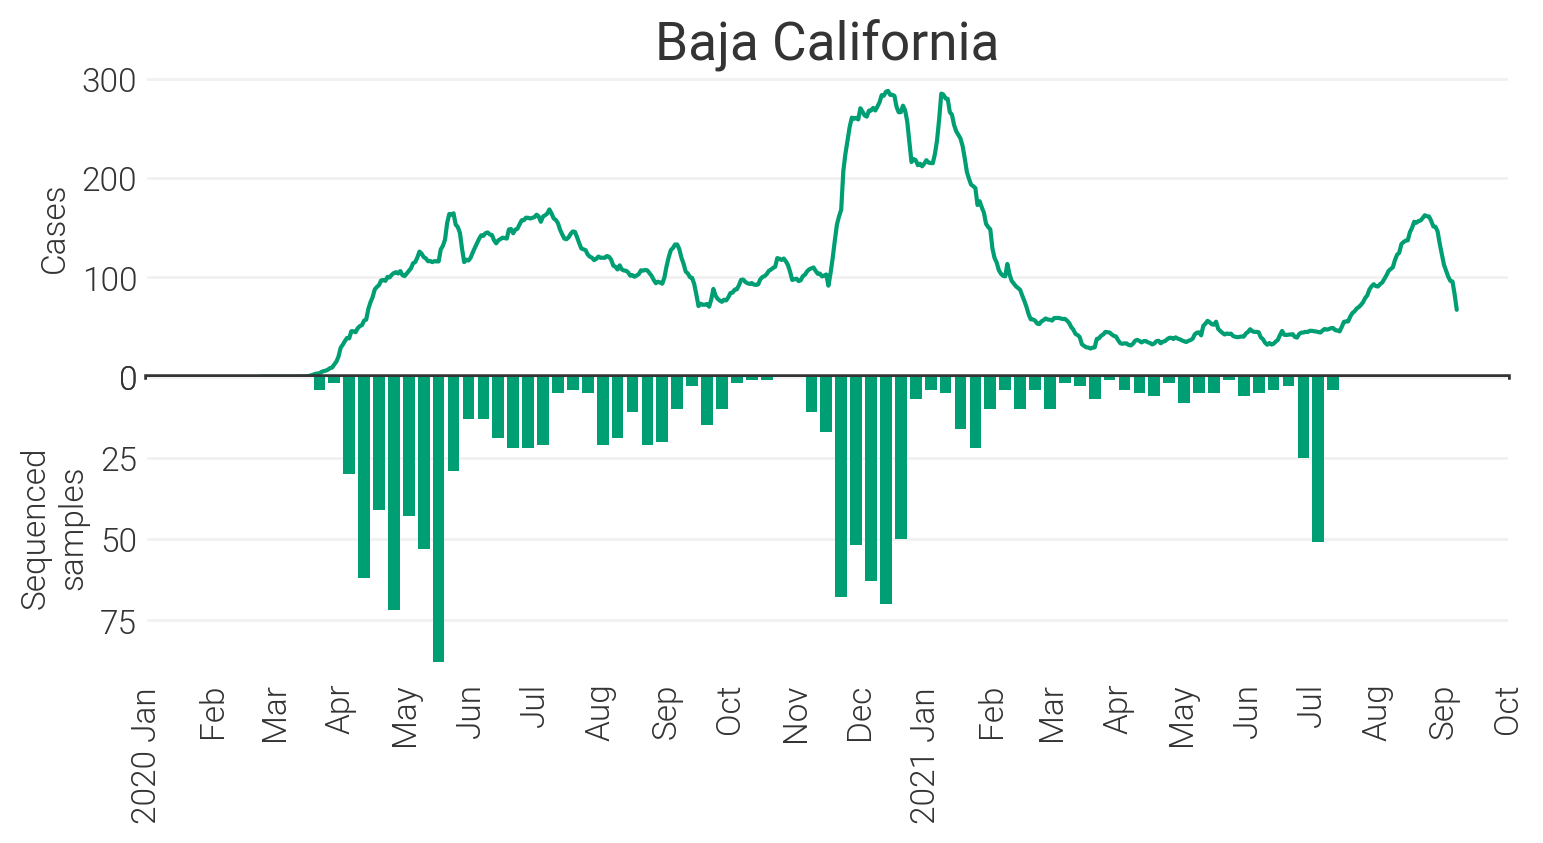

In [67]:
plt.figure( dpi=200, figsize=(8,4.5) )
ax = plt.subplot()
plot_cases_sequences( ax, bc_cases, bc_seqs, "Baja California", color="#009E73" )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_baja-california-sampling.pdf" )
plt.show()